[Digit Recognizer](https://www.kaggle.com/c/digit-recognizer/)

# API Kaggle

Como a base usada é muito grande, não foi possivel deixar no github, então optei por usar a API do kaggle.

In [ ]:
!pip install kaggle

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [5]:
!kaggle competitions download -c digit-recognizer --force

  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 56.1MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 145MB/s]
  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 83.7MB/s]


In [6]:
!unzip -u -d train train.csv.zip

!unzip -u -d test test.csv.zip

Archive:  train.csv.zip
  inflating: train/train.csv         
Archive:  test.csv.zip
  inflating: test/test.csv           


### Importando as bibliotecas do Python

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Leitura da base de treino

In [8]:
train = pd.read_csv('train/train.csv', sep=',', decimal='.', encoding='iso-8859-1')

target = 'label'
features = [ 'pixel'+str(i) for i in range(0, 784) ]

X = train[features]
Y = train[target]

# Questão 1-a
a) Faça o plot de uma imagem de cada uma das classes do problema.

[]

<Figure size 2880x2160 with 0 Axes>

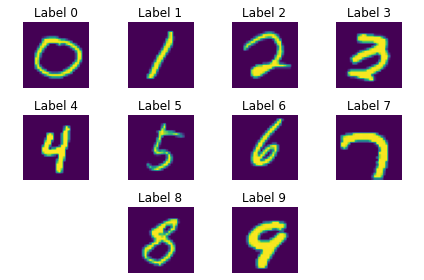

In [9]:
sample_image = np.zeros((10, 784))

for i in range(0, 10):
  idx_label_i = train[target] == i
  sample_image[i,] = train[idx_label_i][features].sample(n=1)

shape = (28,28)

plt.figure(figsize=(40,30))
fig, ax = plt.subplots(3,4)

ax[0,0].imshow(sample_image[0,].reshape(shape))
ax[0,0].set_title('Label 0')
ax[0,1].imshow(sample_image[1,].reshape(shape))
ax[0,1].set_title('Label 1')
ax[0,2].imshow(sample_image[2,].reshape(shape))
ax[0,2].set_title('Label 2')
ax[0,3].imshow(sample_image[3,].reshape(shape))
ax[0,3].set_title('Label 3')

ax[1,0].imshow(sample_image[4,].reshape(shape))
ax[1,0].set_title('Label 4')
ax[1,1].imshow(sample_image[5,].reshape(shape))
ax[1,1].set_title('Label 5')
ax[1,2].imshow(sample_image[6,].reshape(shape))
ax[1,2].set_title('Label 6')
ax[1,3].imshow(sample_image[7,].reshape(shape))
ax[1,3].set_title('Label 7')

ax[2,0].axis('off')
ax[2,1].imshow(sample_image[8,].reshape(shape))
ax[2,1].set_title('Label 8')
ax[2,2].imshow(sample_image[9,].reshape(shape))
ax[2,2].set_title('Label 9')
ax[2,3].axis('off')

for axs in ax.flat:
  axs.axis('off')
  axs.label_outer()

fig.tight_layout()
plt.plot()

# Questão 1-b
b) Faça um histograma mostrando a distribuição das classes do problema. Discuta este histograma.

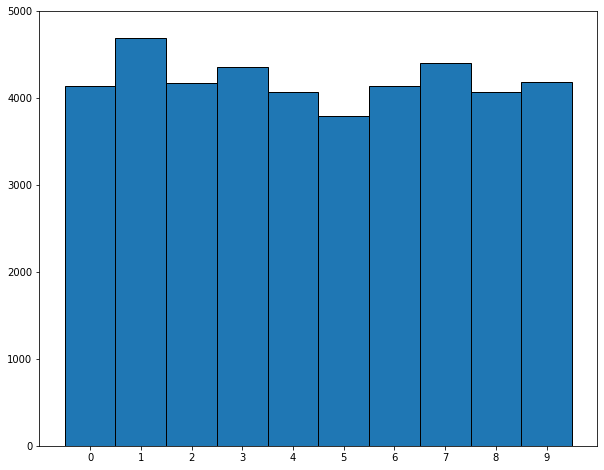

In [10]:
plt.figure(figsize=(10,8))
plt.hist(train['label'], bins=10, range=(0,10), ec="k")
plt.ylim( (0,5000) )
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], ['0','1','2','3','4','5','6','7','8','9'])
plt.show()

Há uma boa distribuição dos números, sendo assim para todas as classes há uma quantidade similar de entradas a serem analisadas pelos algoritmos, fazendo com que eles tenham conhecimento similar sobre cada uma delas. 

# Questão 2-a
a) Detecte variáveis que não são úteis para o modelo e remova elas da base de
dados. Justifique a remoção de tais variáveis. Obs.: as variáveis não podem
ser nem um pouco úteis.

Para encontrarmos quais as variáveis mais e menos relevantes para a análise foi calculada a correlação dos parâmetros.

In [11]:
x_corr = X.corr()

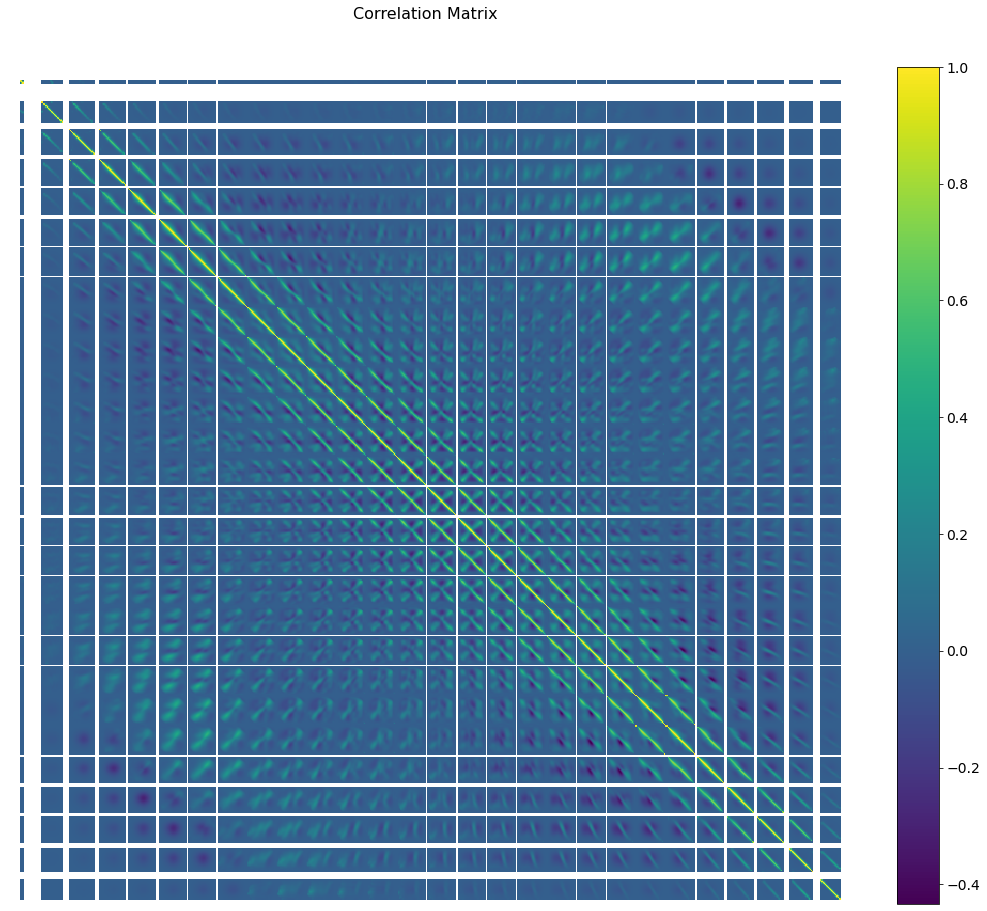

In [12]:
f = plt.figure(figsize=(19, 15))
plt.matshow(x_corr, fignum=f.number)
plt.axis('off')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

Algo a se notar, é que na matriz de correlação temos pixels que aparecem com valor NaN, isso indica que em todos os padrões apresentados eles tem o mesmo valor, dito isso, essas são variavéis que podem ser removidas por não serem úteis.

In [13]:
usable_features = x_corr.dropna(how='all', axis=1).columns.values

# Questão 2-b
b) Usando o critério do item anterior é possível inferir que algumas variáveis devem ter pouca importância para os modelos que iremos construir?

In [14]:
mask_usable_features = np.ones( 784 )

for lbi in usable_features:
  _, x = lbi.split('pixel')
  mask_usable_features[int(x)] = 0

mask_usable_features = mask_usable_features.reshape( (28,28) )

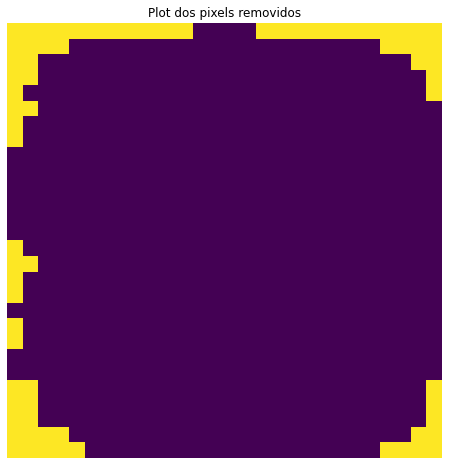

In [15]:
plt.figure(figsize=(10,8))
plt.imshow(mask_usable_features)
plt.axis('off')
plt.title('Plot dos pixels removidos')
plt.show()

Como apresentado no item anterior, vemos que não tem utilidade para o modelo, pois mesmo que haja algo na base de teste, o modelo não foi treinado pra interpretar esses pixels.

# Questão 3-a
a) Comparar vários modelos candidatos e escolher o melhor de acordo com a
acurácia. Usar pelo menos uma rede neural.

In [16]:
X = X[usable_features]

In [17]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, train_size=0.7, random_state=22)

In [18]:
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                        ('scale', MinMaxScaler())])

In [19]:
ct = ColumnTransformer(transformers=[
    (
        'num_transf', 
        numerical_transformer, 
        usable_features
    )
])

pipeline = Pipeline(
    steps=[
        ('ct', ct),
        # estimator: parametro que irá receber os modelos de regrassão
        ('estimator'     , KNeighborsClassifier() )
    ]
)

In [20]:
# params_grid: parametros dos testes para cada modelo
# estimator: recebe a classe do modelo
# estimator__param: parametros especificos para cada modelo
parameters = [
    {
    'estimator'                            : [KNeighborsClassifier()]
    },
    {
    'estimator'                            : [MLPClassifier()]
    },
    {
    'estimator'                            : [RidgeClassifier()]
    },
    {
    'estimator'                            : [SVC()]
    },
    {
    'estimator'                            : [DecisionTreeClassifier()]
    },
    ]

In [21]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    scoring='accuracy',
    cv=3,
)

grid_search.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_transf',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         array(['pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel32', 'pixel33',
       'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39',
       'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel...
       'pixel767', 'pixel768', 'pixel769', 'pixel770', 'pixel771',
       'pixel772', 'pixel773', 'pixel774', 'pixel775', 'pixel776',
      

#Questão 3-b
b) Gerar os resultados do melhor modelo na base de teste e enviar para o
Kaggle. Colocar alguma evidência do envio no projeto entregue.

In [ ]:
grid_search.best_score_

In [ ]:
test = pd.read_csv('test/test.csv', sep=',', decimal='.', encoding='iso-8859-1')
test.head()

In [ ]:
test_submit = pd.DataFrame()
test_submit['ImageId'] = np.arange(1, test.shape[0]+1)
test_submit['Label'] = grid_search.predict(test[usable_features])
test_submit.to_csv("submission.csv", index=False)

In [ ]:
test_submit.head()

In [ ]:
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "Submissão colab"

#Questão 4-a
a) Calcular a acurácia e a matriz de confusão do melhor modelo. Para fazer este item siga os seguintes passos:
- Divida a base de treinamento em 2 partes (70%/30%);
- Treine o modelo na primeira parte e calcule os resultados na segunda;
- Use os hiperparâmetros do melhor modelo da questão 3.

In [22]:
Y_pred = grid_search.predict(X_valid)
cf_mat = confusion_matrix(Y_valid, Y_pred)

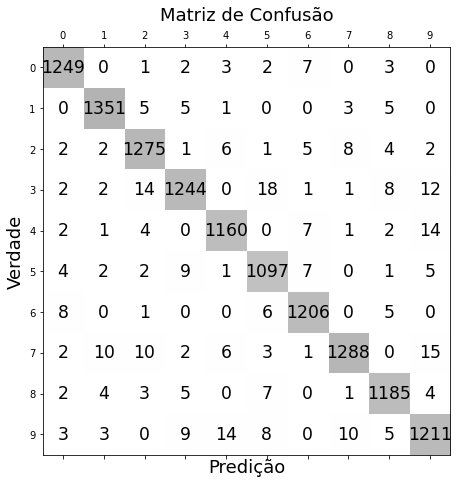

In [23]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cf_mat, cmap=plt.cm.binary, alpha=0.3)
for i in range(cf_mat.shape[0]):
    for j in range(cf_mat.shape[1]):
        ax.text(x=j, y=i,s=cf_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predição', fontsize=18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['0','1','2','3','4','5','6','7','8','9'])
plt.ylabel('Verdade', fontsize=18)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['0','1','2','3','4','5','6','7','8','9'])
plt.title('Matriz de Confusão', fontsize=18)
plt.show()

In [24]:
accur = np.sum(cf_mat.diagonal())/np.sum(cf_mat)
print('Acurácia: ', round(accur,5))

Acurácia:  0.97341


# Questão 4-b
b) O modelo tem um resultado parecido para todas as classes, ou há uma
grande diferença em seu comportamento (quantidade acertos e erros) para
diferentes classes?

Pela matriz de confusão pode-se observar que as classes que menos foram confundidas com outras foi o 0 e o 6, enquanto o que mais se confundiu foi o 9, possivelmente por conta de suas morfologias, mesmo assim não podemos dizer que há um grande vies na classificação, pois obteve-se êxito para todas as classes.